# **AI-CAPTCHA SOLVER**

# **Environmental SetUp**

In [1]:
# Main libraries
import os
import numpy as np
import pandas as pd
import tensorflow as tf

# Data
from glob import glob
from sklearn.model_selection import train_test_split

# Data Visualization
import plotly.express as px
import matplotlib.pyplot as plt

# Neural Network
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# Constants
BATCH_SIZE = 32
HEIGHT, WIDTH = 50, 200

# **Captchas Dataset**

Today, we're diving into a **fascinating dataset featuring captchas!** These are the **quirky image puzzles** we've all encountered, especially during those **verification processes on Google**. Remember those? Well, we've got **1040 of those captivating images** ready to be **explored.**

While captchas used to be everywhere, they're not as prominent in modern applications, thanks to advancements in technology. However, they still pop up on some government sites. But guess what? We're about to use some **machine learning magic** to **crack them wide open**! Let's do this!

In [3]:
# Data Configs
data_path = 'D:\\AI\\archive (1)\\samples'

# Get all the file names
captcha_files = glob(data_path + "/*")
captcha_files.remove('D:\\AI\\archive (1)\\samples\\samples')

print(f"Total Samples: {len(captcha_files)}")
print(f"Samples: {captcha_files[:5]}")

Total Samples: 1070
Samples: ['D:\\AI\\archive (1)\\samples\\226md.png', 'D:\\AI\\archive (1)\\samples\\22d5n.png', 'D:\\AI\\archive (1)\\samples\\2356g.png', 'D:\\AI\\archive (1)\\samples\\23mdg.png', 'D:\\AI\\archive (1)\\samples\\23n88.png']


Now that we've **gathered all the file paths**, each representing respective **captcha images**, let's take a closer look. If you observe carefully, you'll notice that each **file path** bears a **filename**, which directly **corresponds to the text depicted in the captcha.**

Leveraging this information, we can **effortlessly construct** a **dataset** comprising **images paired with their corresponding labels**, facilitating our analysis and model training process.

In [4]:
# Features & Labels
image_paths = captcha_files
labels = [path.split('/')[-1].split('.')[0] for path in image_paths]

print(f"Labels: {labels[:5]}")

Labels: ['D:\\AI\\archive (1)\\samples\\226md', 'D:\\AI\\archive (1)\\samples\\22d5n', 'D:\\AI\\archive (1)\\samples\\2356g', 'D:\\AI\\archive (1)\\samples\\23mdg', 'D:\\AI\\archive (1)\\samples\\23n88']


These labels serve as a crucial starting point for our task. However, to progress further, we need to **extract additional information from them**. Specifically, we need to determine the **complete set of characters** present in the captchas, as well as identify the **maximum length** of a **captcha**.

These details are essential for **effectively developing our model**, enabling us to **appropriately preprocess** the **data and design a robust framework** capable of **accurately recognizing captchas of varying lengths and character compositions.**

In [5]:
# Extract the set of Unique Characters
unique_chars = sorted(set(char for label in labels for char in label))
print(f"Unique Chars: {unique_chars}")
print(f"Total Number of Unique Chars: {len(unique_chars)}")

Unique Chars: [' ', '(', ')', '1', '2', '3', '4', '5', '6', '7', '8', ':', 'A', 'D', 'I', '\\', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'l', 'm', 'n', 'p', 'r', 's', 'v', 'w', 'x', 'y']
Total Number of Unique Chars: 35


In total, we have **19 unique characters**.

In [6]:
# The max length os the Captchas
max_len = max((len(label) for label in labels))
print(f"Max length of Captcha: {max_len}")

Max length of Captcha: 31


In our dataset, the **maximum length** of a captcha is **5 characters**. However, computers inherently **process numbers** rather than **text**. To bridge this gap, we need to **convert the textual information** into **numerical representations**.

One common approach is **text vectorization**, also known as **string lookup.** This technique involves **mapping each character in the text to a unique numerical value,** effectively transforming the **text data** into a format that computers can **readily understand and process**.

In [7]:
# Mapping Chars to Nums
char_to_num = layers.StringLookup(vocabulary=unique_chars, mask_token=None)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

In [8]:
print(f"Vocab: {char_to_num.get_vocabulary()}")

Vocab: ['[UNK]', ' ', '(', ')', '1', '2', '3', '4', '5', '6', '7', '8', ':', 'A', 'D', 'I', '\\', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'l', 'm', 'n', 'p', 'r', 's', 'v', 'w', 'x', 'y']


In [9]:
# Splitting data into Training and Testing Counter parts
X_train, X_test, y_train, y_test = train_test_split(image_paths, labels, test_size=0.1, shuffle=True, random_state=42)

# Training & Testing Dataset
raw_train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
raw_test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

print(f"Training Size : {len(X_train)} samples.")
print(f"Testing Size  : {len(X_test)} samples.")

Training Size : 963 samples.
Testing Size  : 107 samples.


The existing data is currently in **textual format**, and to **facilitate numerical processing**, we need to map it to a **numerical format**. A **convenient and effective method** to achieve this is by utilizing **TensorFlow Datasets (tfds).**

In [10]:
def preprocess(image_path, label):

    # Load image from image path
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, (HEIGHT, WIDTH))
    image = image/255.
    image = tf.cast(image, tf.float32)

    # Convert label to numerical label
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))

    return {"ImageInput":image, "LabelInput":label}

In [11]:
# Apply the preprocessing function
train_ds = raw_train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = raw_test_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

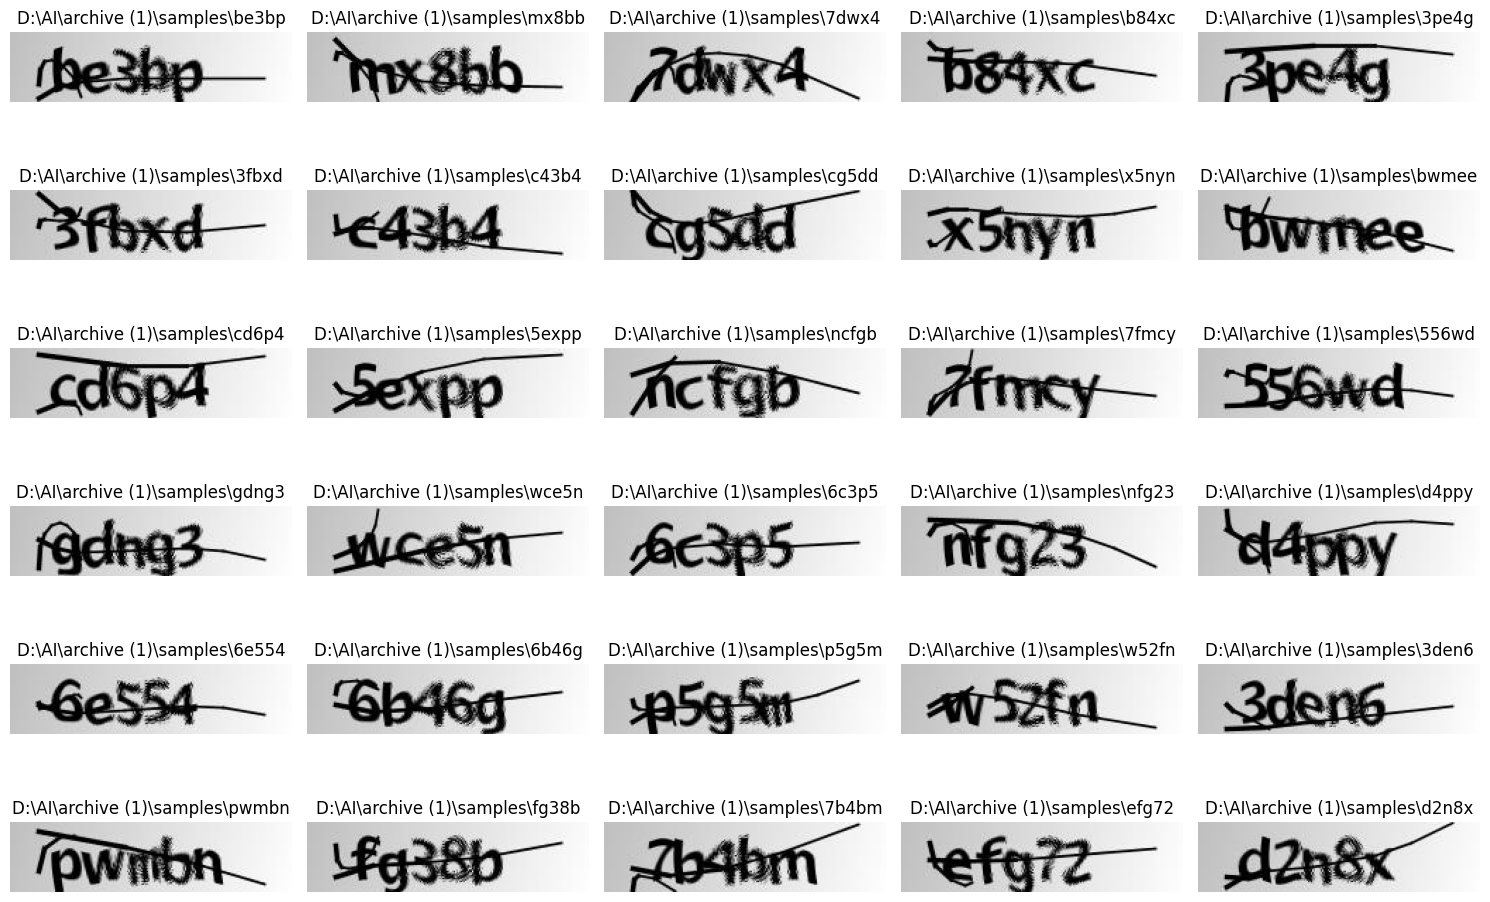

In [12]:
# Loop over images
plt.figure(figsize=(15, 10))

# Select a set of images
data = next(iter(train_ds.batch(32)))
images, labels = data['ImageInput'], data['LabelInput']

# Loop over the subset
for index in range(1, 31):

    # Extract info
    image = images[index]
    text_label = tf.strings.reduce_join(num_to_char(labels[index])).numpy().decode("utf-8")

    # Plot the subplot
    plt.subplot(6, 5, index)
    plt.imshow(image)
    plt.title(text_label)
    plt.axis('off')

# Plot Configs
plt.tight_layout()
plt.show()

In [13]:
# Final process
train_ds = train_ds.repeat(5).shuffle(1000).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)

# **CTC Loss**

**Connectionist Temporal Classification** (CTC) loss is a crucial component in training **sequence-to-sequence models**, particularly in tasks involving **variable-length input and output sequences** such as **speech recognition**, **handwriting recognition**, and **machine translation**. **CTC loss** allows the model to learn alignments between **input sequences and target sequences** without requiring explicit alignment information during training. Let's break down **CTC loss** in detail, including its **mathematical formulation** and a **real-life analogy.**

> **Mathematical Formulation:**

Given an input sequence **X = (x1, x2, ..., xT)** and a target sequence **Y = (y1, y2, ..., yU),** where **T** and **U** denote the lengths of the **input and target sequences** respectively, the goal is to compute the **probability distribution** over all possible alignments of **X to Y**. **CTC loss** achieves this by introducing a blank symbol **'-'** and computing the **probability of all possible output sequences $Y^`$ given X**.

Let's denote **S** as the **set of all possible output sequences** containing characters **y** from the target alphabet **Y** along with the blank symbol **'-'.** The **CTC loss** is defined as the **negative log probability** of the **target sequence given the input sequence**:

> **CTC Loss** = - log $∑$ ($Y^`$ in S) / P($Y^`$ | X)

The probability P($Y^`$ | X) is computed by summing over all possible alignments between X and $Y^`$, taking into account both valid and blank symbols.

> **Real-Life Analogy:**

Imagine you have a friend who's a bit of a mumbler, and you're trying to transcribe what they're saying. Your friend speaks in a stream of sounds, but you're not always sure which sounds correspond to which words, and sometimes they pause or repeat sounds.

- **Speech Recognition Task**: Your friend's speech is like the input sequence X, and your transcription is the target sequence Y.

- **Blank Symbols**: Sometimes your friend mumbles or makes unclear sounds. You introduce the blank symbol '-' to represent these unclear moments.

- **All Possible Transcriptions**: You try out different transcriptions of your friend's speech, including variations with pauses and repetitions, just like considering all possible alignments in CTC.

- **CTC Loss**: The negative log probability of your final transcription given your friend's speech represents how accurate your transcription is. Minimizing this loss means finding the most likely transcription given the input speech.

In summary, **CTC loss** enables training **sequence-to-sequence models** for tasks where the alignment between **input and output sequences** is not known beforehand. By considering **all possible alignments** and **incorporating a blank symbol**, **CTC loss** allows the model to learn to transcribe **variable-length sequences accurately.**

For detailed information: [CTC Loss](https://ogunlao.github.io/blog/2020/07/17/breaking-down-ctc-loss.html)


---

The **CTC Loss/Layer** is a **crucial component** in an ***OCR model*** as it helps to calculate the **probability distribution** of different characters in an **input image sequence**, and enables the model to **recognize text** in challenging and ***variable handwriting styles.***

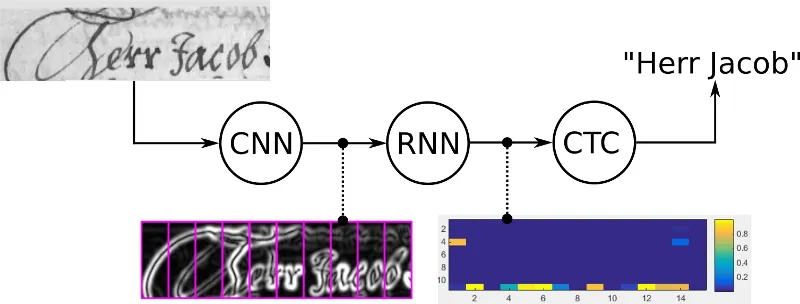

**CTC (Connectionist Temporal Classification) loss** is a loss function used in **deep learning models** for **sequence-to-sequence tasks** such as ***speech recognition, handwriting recognition, and text recognition***. The **CTC loss** is used to compute the **difference between the predicted output and the ground truth label**.

In the context of ***handwriting recognition***, the **CTC loss** takes in the **predicted sequence of characters** (in the form of **probability distribution** over the characters) and the **actual ground truth label** (which is a sequence of characters) and computes the difference between them. Since the length of the **predicted sequence** can be different from the **length of the ground truth label**, the **CTC loss** is used to align the **two sequences** by adding **blank characters** between the characters of the **predicted sequence**. This ensures that the length of the **predicted sequence matches the length of the ground truth label**.

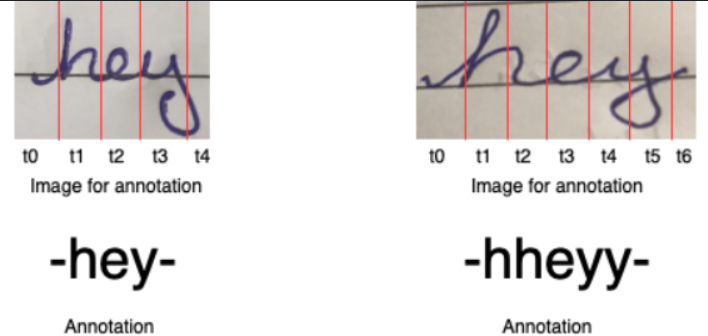

The **CTC loss** is calculated by **summing over all possible alignments** between the **predicted sequence** and the **ground truth label**. This is done by **dynamic programming**, which finds the most likely path through the **probability distribution of characters**. The **CTC loss function** then computes the **negative log probability** of the correct alignment. The goal of the **CTC loss** is to **minimize the difference between the predicted sequence and the ground truth label**.

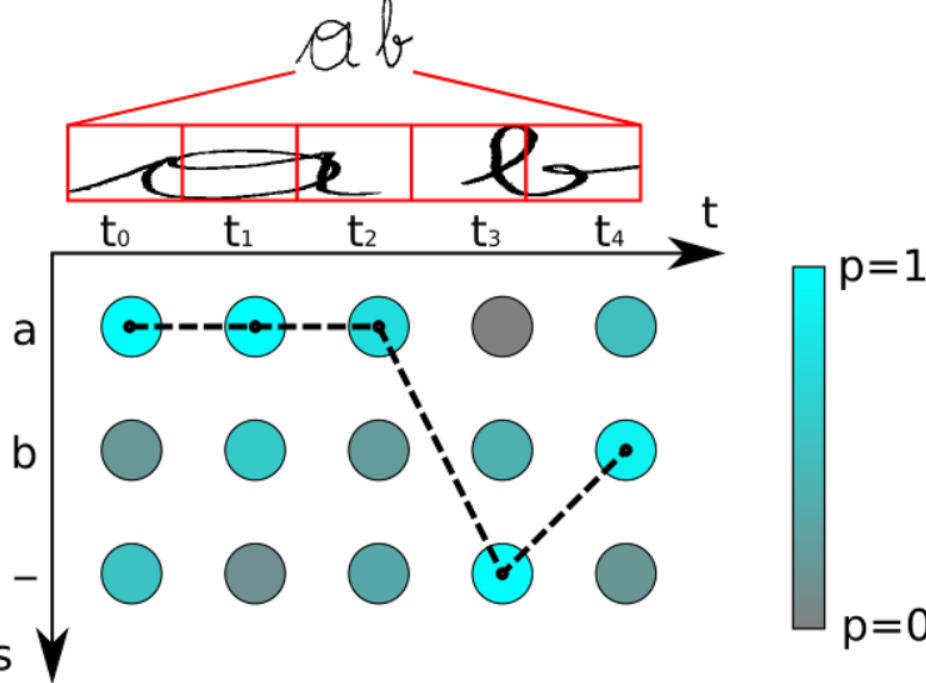

In summary, the **CTC loss** is used in ***sequence-to-sequence tasks*** to align the **predicted sequence and the ground truth label** by adding ***blank characters*** between the characters of the predicted sequence. The **CTC loss** is calculated by **dynamic programming**, and its goal is to ***minimize the difference between the predicted sequence and the ground truth label***.

In [14]:
class CTCLayer(layers.Layer):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.ctc_batch_loss = keras.backend.ctc_batch_cost

    def call(self, true, pred):

        batch_size = tf.cast(
            tf.shape(true)[0],
            dtype='int64'
        )

        input_length = tf.cast(
            tf.shape(pred)[1],
            dtype='int64'
        )

        output_length = tf.cast(
            tf.shape(true)[1],
            dtype='int64'
        )

        input_length *= tf.ones(shape=(batch_size, 1), dtype='int64')
        output_length *= tf.ones(shape=(batch_size, 1), dtype='int64')

        loss = self.ctc_batch_loss(true, pred, input_length, output_length)
        self.add_loss(loss)

        return pred

# **CTC Model**

Once we have defined the CTC Loss Layer, we can seamlessly integrate it into our main model architecture. However, at this stage, we haven't yet designed the primary model responsible for processing image inputs, utilizing an encoder (based on CNN), and generating output sequences via a decoder (based on LSTM).

We need to establish the main model architecture that encompasses these components, ensuring a cohesive flow from image input to sequence output. Once we have this architecture in place, we can incorporate the CTC Loss Layer, enabling effective training for tasks such as image-to-text conversion or sequence generation.

In [15]:
# CNN Encoder
encoder = keras.Sequential([
    layers.Input(shape=(HEIGHT, WIDTH, 3), dtype='float32'),
    layers.Conv2D(
        filters=32,
        kernel_size=3,
        padding='same',
        activation='relu',
        kernel_initializer='he_normal',
        name="ConvLayer1"
    ),
    layers.MaxPool2D(name="MaxPoolLayer1"),
    layers.Conv2D(
        filters=64,
        kernel_size=3,
        padding='same',
        activation='relu',
        kernel_initializer='he_normal',
        name="ConvLayer2"
    ),
    layers.MaxPool2D(name="MaxPoolLayer2"),
    layers.Reshape(target_shape=(WIDTH//4, (HEIGHT//4)*64), name="ReshapeEmbedding"),
    layers.Dense(64, activation='relu', kernel_initializer='he_normal', name="ImageEmbeding")

], name="CNN-Encoder")

In [16]:
# LSTM Decoder
decoder = keras.Sequential([
    layers.Bidirectional(layers.LSTM(32, return_sequences=True, dropout=0.25), name="LSTMLayer1"),
    layers.Bidirectional(layers.LSTM(32, return_sequences=True, dropout=0.25), name="LSTMLayer2"),
], name="LSTM-Decoder")

In [17]:
# Input layers for the Image and Label input
image_input = layers.Input(shape=(HEIGHT, WIDTH, 3), dtype='float32', name="ImageInput")
label_input = layers.Input(shape=(None, ), dtype='float32', name="LabelInput")

# Encoder & decoder network
embeddings = encoder(image_input)
dropout = layers.Dropout(0.5, name="EmbeddingDropout")(embeddings)
output_seq = decoder(dropout)
output_seq = layers.Dense(units=len(char_to_num.get_vocabulary())+1, activation='softmax', name="OutputSequence")(output_seq)

# CTC Loss Layer
ctc_loss = CTCLayer(name="CTCLoss")(label_input, output_seq)

# CTC Model
ctc_model = keras.Model(
    inputs=[image_input, label_input],
    outputs=[ctc_loss],
    name="CTCModel"
)

# Model Architecture Summary
ctc_model.summary()

Model: "CTCModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ImageInput          │ (None, 50, 200,   │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CNN-Encoder         │ (None, 50, 64)    │     68,608 │ ImageInput[0][0]  │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ EmbeddingDropout    │ (None, 50, 64)    │          0 │ CNN-Encoder[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM-Decoder        │ (None, 50, 64)    │     49,664 │ EmbeddingDropout… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LabelInput          │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ OutputSequence      │ (None, 50, 37)    │      2,405 │ LSTM-Decoder[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CTCLoss (CTCLayer)  │ (None, 50, 37)    │          0 │ LabelInput[0][0], │
│                     │                   │            │ OutputSequence[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 120,677 (471.39 KB)

 Trainable params: 120,677 (471.39 KB)

 Non-trainable params: 0 (0.00 B)

# **Model Visualization**

In [22]:
pip install pydot


Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: pydot in c:\users\lenovo\appdata\local\programs\python\python311\lib\site-packages (2.0.0)



In [23]:
# Convert to a DataFrame
history_df = pd.DataFrame(history.history)

# Visualize the History
fig = px.line(history_df, y=["loss", "val_loss"], title="Learning Curve")
fig.update_layout(
    xaxis_title="Epochs",
    yaxis_title="Sparse Categorical Crossentropy",
)
fig.show()

profile = ProfileReport(history_df, minimal=True)
profile.to_file('report.html')


NameError: name 'ProfileReport' is not defined

The **model architecture** is depicted in the **accompanying figure**. It features **two inputs**: one for **image data** and the **other for label information**. The **image input** undergoes processing through a **series of encoder and decoder layers**, culminating in the **generation of outputs**.

These outputs are then fed into the **CTC Loss Layer** alongside the **true output labels** to compute the **CTC Loss**. This comprehensive approach enables the **model to learn and optimize** its performance for tasks such as **image-to-text conversion or sequence generation**.

# **Model Training**

During the **compilation phase** of **model training**, we do not explicitly specify a **loss function** because the **CTC Loss** is computed internally within the **model architecture**. The model has been designed to incorporate the **CTC Loss Layer**, which automatically computes the **loss** based on the **decoder outputs** and the **true output labels**.

Therefore, we can omit specifying a **loss function** during compilation, allowing the model to **internally handle the computation of the CTC Loss** during training. This streamlined approach simplifies **the training process** and ensures that the model learns effectively from the provided data.

In [20]:
# Model Compilation
ctc_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3))

# Model Callbacks
early_stopping = keras.callbacks.EarlyStopping(patience=5, monitor="val_loss", restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3
)

# Model training
history = ctc_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=[
        early_stopping,
        lr_scheduler
    ]
)

Epoch 1/10


151/151 ━━━━━━━━━━━━━━━━━━━━ 29s 150ms/step - loss: 11.2646 - val_loss: 11.5783 - learning_rate: 0.0010
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 22s 147ms/step - loss: 10.9880 - val_loss: 11.3266 - learning_rate: 0.0010
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 23s 150ms/step - loss: 10.7640 - val_loss: 11.2097 - learning_rate: 0.0010
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 23s 150ms/step - loss: 10.4924 - val_loss: 11.2964 - learning_rate: 0.0010
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 23s 153ms/step - loss: 10.4124 - val_loss: 10.9780 - learning_rate: 0.0010
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 23s 152ms/step - loss: 10.1139 - val_loss: 10.9105 - learning_rate: 0.0010
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 22s 145ms/step - loss: 9.9542 - val_loss: 10.7177 - learning_rate: 0.0010
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 23s 154ms/step - loss: 9.8063 - val_loss: 10.5100 - learning_rate: 0.0010
Epoch 9/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 23s 156ms/step - loss: 9.5730 - val_loss: 10.4194 - l

# **Model Inference**

Let's testthe model performance on the test dataset.

In [24]:
testing_loss = ctc_model.evaluate(test_ds,  verbose=0)
print(f"Model Testing Loss: {testing_loss}")

Model Testing Loss: 10.299565315246582


In order to make predictions, we need a different model. A model that gives us Outputs instead of the CTC layer output. That's why we make a new OCR prediction model that takes inputs similarly, but the output is the output sequence, not the CTC layer output.

In [25]:
# Define input and output tensors
image_input_tensor = ctc_model.inputs[0]
output_sequence_tensor = ctc_model.get_layer("OutputSequence").output

# Create the prediction model using input and output tensors
ocr_pred_model = keras.Model(inputs=image_input_tensor, outputs=output_sequence_tensor)
ocr_pred_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ImageInput (InputLayer)         │ (None, 50, 200, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ CNN-Encoder (Sequential)        │ (None, 50, 64)         │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ EmbeddingDropout (Dropout)      │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM-Decoder (Sequential)       │ (None, 50, 64)         │        49,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ OutputSequence (Dense)          │ (None, 50, 37)         │         2,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,677 (471.39 KB)

 Trainable params: 120,677 (471.39 KB)

 Non-trainable params: 0 (0.00 B)

Although now we have the output. These outputs are still a bunch of sequences, and we need to convert these sequences back to a single sequence, which is our final result. In order to do so, we need to just reverse the process of the CTC loss.

In [26]:
def decode_prediction(model_pred_seq):

    # Compute the Input length
    input_length = np.ones(model_pred_seq.shape[0]) * model_pred_seq.shape[1]

    # Decode the model predictions (& select the required stuff)
    decode = tf.squeeze(keras.backend.ctc_decode(model_pred_seq, input_length=input_length, greedy=True)[0])

    # Conver the numbers to their respective characters
    decoded_text = [tf.strings.reduce_join(num_to_char(nums)) for nums in decode]

    # Convert thode characters back to a normal string
    decoded_text = [text.numpy().decode().replace('[UNK]', '') for text in decoded_text]

    return decoded_text

Let's see the predictions visually.

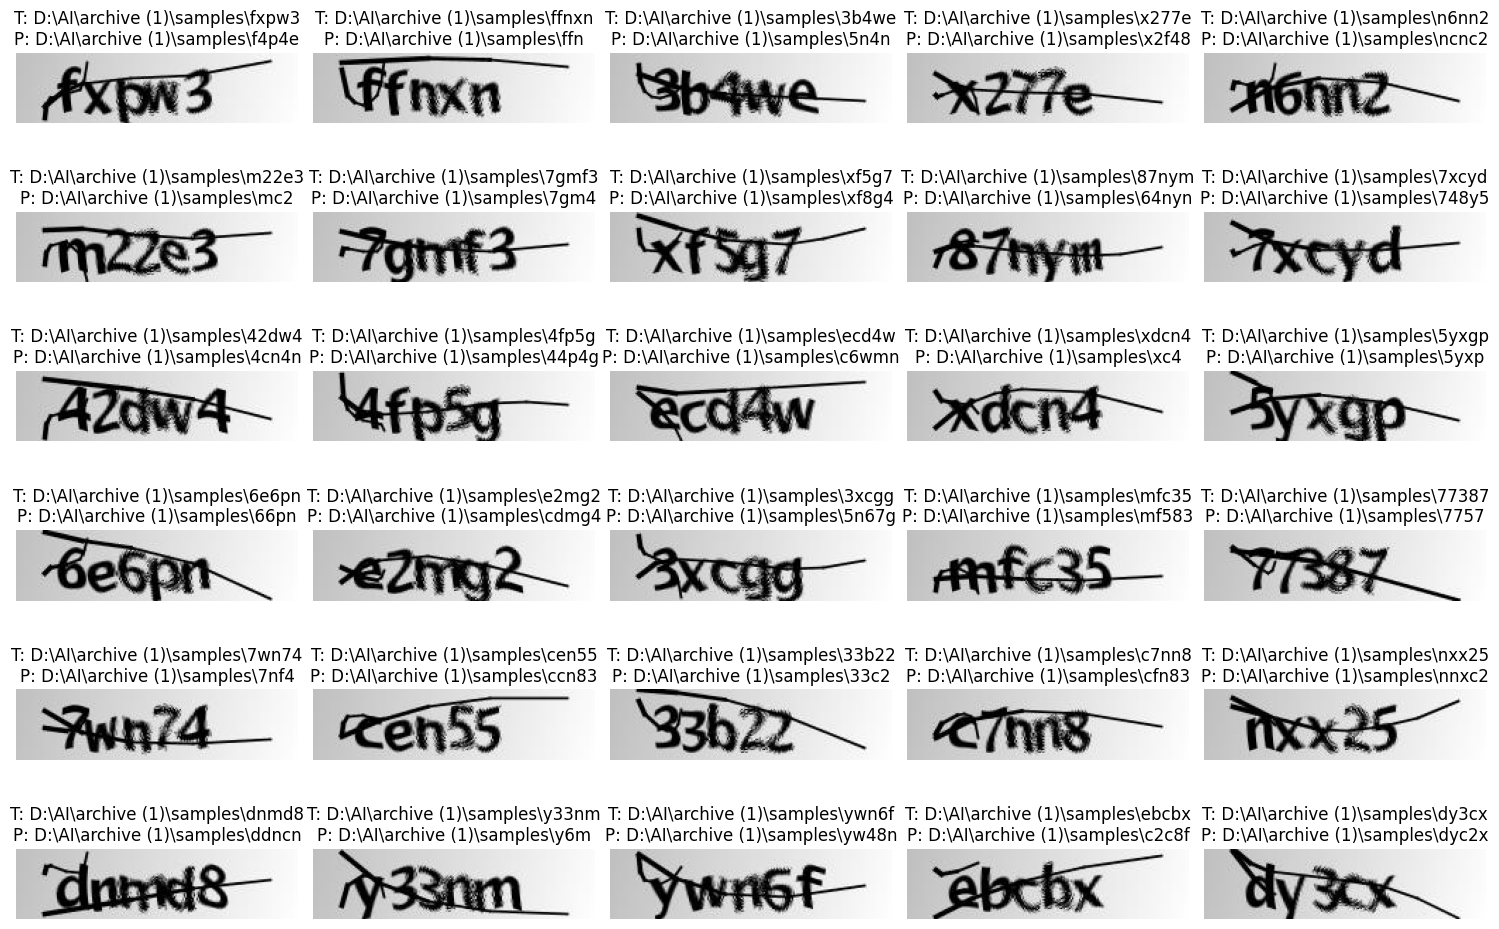

In [27]:
# Initialize Figure Size
plt.figure(figsize=(15, 10))

# Loop over a subset of images in the dataset
for data in test_ds.take(1):

    # Loop over individual images and labels
    images = data['ImageInput']
    labels = data['LabelInput']
    model_preds = decode_prediction(ocr_pred_model.predict(images, verbose=0))

    for index in range(min(30, len(images))):

        # Extract info for each image and label
        image = images[index]
        true_label = labels[index]
        pred_label = model_preds[index]

        # Decode labels from numerical to text
        true_text = tf.strings.reduce_join(num_to_char(true_label)).numpy().decode("utf-8")

        # Plot the subplot
        plt.subplot(6, 5, index + 1)
        plt.imshow(image)  # Assuming images are grayscale
        plt.title(f'T: {true_text}\nP: {pred_label}')
        plt.axis('off')

# Plot Configs
plt.tight_layout()
plt.show()